In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load Dataset

In [2]:
import mlflow
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset
from hcmus.models import FasterRCNNWrapper

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-03-23 16:08:50.860 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True


In [3]:
mlflow.set_tracking_uri(appconfig.MLFLOW_TRACKING_URI)
mlflow.set_experiment(appconfig.MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='/mlflow/mlruns/1', creation_time=1742697703421, experiment_id='1', last_update_time=1742697703421, lifecycle_stage='active', name='ItemIdentification', tags={}>

In [4]:
torch_device = "cpu"
train_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
)
train_dataset = LbsDataset(train_connector, device=appconfig.TORCH_DEVICE, augmentation=True)
train_loader = train_dataset.get_dataloader(shuffle=True, batch_size=1)

Loading tasks:   4%|▍         | 4/100 [00:05<02:19,  1.46s/it]
2025-03-23 16:08:58.330 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 203
2025-03-23 16:08:58.331 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 1591


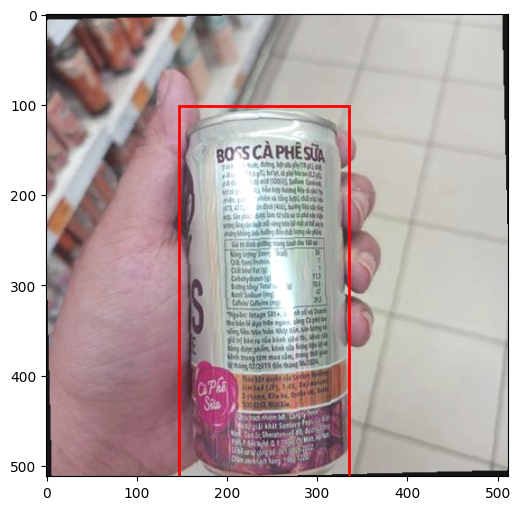

In [5]:
from hcmus.utils import viz_utils
tensor, target = train_dataset[1]
image = train_dataset.tensor_to_image(tensor)
viz_utils.draw_boxes(image, target["boxes"].cpu())

# 2. Finetune Model

In [6]:
model = FasterRCNNWrapper(len(train_dataset._labels), device=torch_device)

2025-03-23 16:08:58.891 | INFO     | hcmus.models._faster_rcnn:__init__:22 - Use torch device: cpu


In [7]:
model.train(train_loader, hyper_params={
    "num_epochs": 16,
    "lr": 1e-4,
    "momentum": 0.9,
    "weight_decay": 1e-5
})

2025-03-23 16:09:00.594 | INFO     | hcmus.models._faster_rcnn:train:58 - Epoch 1/16 - Training loss: 4.9514
2025-03-23 16:09:00.892 | INFO     | hcmus.models._faster_rcnn:train:67 - Save new model at model-0.pth
2025-03-23 16:09:02.319 | INFO     | hcmus.models._faster_rcnn:train:58 - Epoch 2/16 - Training loss: 5.5061
2025-03-23 16:09:03.787 | INFO     | hcmus.models._faster_rcnn:train:58 - Epoch 3/16 - Training loss: 4.8196
2025-03-23 16:09:04.064 | INFO     | hcmus.models._faster_rcnn:train:67 - Save new model at model-2.pth
2025-03-23 16:09:05.476 | INFO     | hcmus.models._faster_rcnn:train:58 - Epoch 4/16 - Training loss: 4.7232
2025-03-23 16:09:05.811 | INFO     | hcmus.models._faster_rcnn:train:67 - Save new model at model-3.pth
2025-03-23 16:09:07.222 | INFO     | hcmus.models._faster_rcnn:train:58 - Epoch 5/16 - Training loss: 4.6891
2025-03-23 16:09:07.555 | INFO     | hcmus.models._faster_rcnn:train:67 - Save new model at model-4.pth
2025-03-23 16:09:08.911 | INFO     | hc

🏃 View run trusting-sloth-528 at: http://jimica.ddns.net:5000/#/experiments/1/runs/7a16a8aefcc742c9b58eb267ee9412ea
🧪 View experiment at: http://jimica.ddns.net:5000/#/experiments/1
